In [35]:
your_name = "AsfiyaSuzain"

!mkdir -p ds_{your_name}/csv_files
!mkdir -p ds_{your_name}/outputs
!touch ds_{your_name}/README.md


In [36]:
import gdown


historical_url = "https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"


fear_greed_url = "https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"

gdown.download(historical_url, f"ds_{your_name}/csv_files/historical_trader_data.csv", quiet=False)
gdown.download(fear_greed_url, f"ds_{your_name}/csv_files/fear_greed_index.csv", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_AsfiyaSuzain/csv_files/historical_trader_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 80.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_AsfiyaSuzain/csv_files/fear_greed_index.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 20.4MB/s]


'ds_AsfiyaSuzain/csv_files/fear_greed_index.csv'

In [37]:
import pandas as pd

# Load datasets
trader_df = pd.read_csv(f"ds_{your_name}/csv_files/historical_trader_data.csv")
sentiment_df = pd.read_csv(f"ds_{your_name}/csv_files/fear_greed_index.csv")

# Print columns for both datasets to check
print("Trader Data Columns:")
print(trader_df.columns)

print("\nSentiment Data Columns:")
print(sentiment_df.columns)


Trader Data Columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

Sentiment Data Columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')


In [38]:
# Rename columns in trader_df to easy lowercase names
trader_df.rename(columns={
    'Account': 'account',
    'Coin': 'symbol',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Timestamp IST': 'timestamp_ist',
    'Start Position': 'start_position',
    'Direction': 'direction',
    'Closed PnL': 'closed_pnl',
    'Transaction Hash': 'transaction_hash',
    'Order ID': 'order_id',
    'Crossed': 'crossed',
    'Fee': 'fee',
    'Trade ID': 'trade_id',
    'Timestamp': 'timestamp'
}, inplace=True)

# Convert 'timestamp_ist' or 'timestamp' to datetime, whichever exists
if 'timestamp_ist' in trader_df.columns:
    trader_df['timestamp'] = pd.to_datetime(trader_df['timestamp_ist'], errors='coerce')
else:
    trader_df['timestamp'] = pd.to_datetime(trader_df['timestamp'], errors='coerce')

# Check if datetime conversion worked
print(trader_df[['timestamp_ist', 'timestamp']].head())


      timestamp_ist           timestamp
0  02-12-2024 22:50 2024-02-12 22:50:00
1  02-12-2024 22:50 2024-02-12 22:50:00
2  02-12-2024 22:50 2024-02-12 22:50:00
3  02-12-2024 22:50 2024-02-12 22:50:00
4  02-12-2024 22:50 2024-02-12 22:50:00


In [40]:
# Step 4 fixed: Prepare Date_only columns and check date ranges safely

# Create date-only columns for merging (date without time)
trader_df['Date_only'] = pd.to_datetime(trader_df['timestamp'], errors='coerce').dt.date

# For sentiment data, clean columns & rename if necessary
sentiment_df.columns = sentiment_df.columns.str.strip()  # remove spaces
if 'Date' not in sentiment_df.columns and 'date' in sentiment_df.columns:
    sentiment_df.rename(columns={'date': 'Date'}, inplace=True)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], errors='coerce')
sentiment_df['Date_only'] = sentiment_df['Date'].dt.date

# Drop missing values before min/max
valid_trader_dates = trader_df['Date_only'].dropna()
valid_sentiment_dates = sentiment_df['Date_only'].dropna()

print("Trader data date range:", valid_trader_dates.min(), "to", valid_trader_dates.max())
print("Sentiment data date range:", valid_sentiment_dates.min(), "to", valid_sentiment_dates.max())


Trader data date range: 2023-01-05 to 2025-12-04
Sentiment data date range: 2018-02-01 to 2025-05-02


In [41]:
start_date = sentiment_df['Date_only'].min()
end_date = sentiment_df['Date_only'].max()

filtered_trader_df = trader_df[(trader_df['Date_only'] >= start_date) & (trader_df['Date_only'] <= end_date)]

print("Filtered trader data date range:", filtered_trader_df['Date_only'].min(), "to", filtered_trader_df['Date_only'].max())
print("Rows after filtering:", len(filtered_trader_df))


Filtered trader data date range: 2023-01-05 to 2025-05-02
Rows after filtering: 35864


In [43]:
# Step 6: Fix column names in sentiment_df before merge

# Strip whitespace from all column names
sentiment_df.columns = sentiment_df.columns.str.strip()

# Check if 'Classification' column exists (case-insensitive)
if 'Classification' not in sentiment_df.columns:
    for col in sentiment_df.columns:
        if col.lower() == 'classification':
            sentiment_df.rename(columns={col: 'Classification'}, inplace=True)
            break

# Now merge filtered trader data with sentiment data on 'Date_only'
merged_df = pd.merge(
    filtered_trader_df,
    sentiment_df[['Date_only', 'Classification']],
    on='Date_only',
    how='left'
)

# Show sample rows and counts of valid rows
print("Merged data sample:")
print(merged_df[['Date_only', 'side', 'closed_pnl', 'Classification']].head())

valid_rows = merged_df[merged_df['side'].notna() & merged_df['Classification'].notna()]
print("Rows with valid 'side' and 'Classification':", len(valid_rows))


Merged data sample:
    Date_only side  closed_pnl Classification
0  2024-02-12  BUY         0.0          Greed
1  2024-02-12  BUY         0.0          Greed
2  2024-02-12  BUY         0.0          Greed
3  2024-02-12  BUY         0.0          Greed
4  2024-02-12  BUY         0.0          Greed
Rows with valid 'side' and 'Classification': 35864


Average Closed PnL by Market Sentiment:
Classification
Extreme Fear       1.891632
Extreme Greed    205.816345
Fear             128.287950
Greed             53.988003
Neutral           27.088803
Name: closed_pnl, dtype: float64


/tmp/ipython-input-2183096698.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette=["red", "green"])
/tmp/ipython-input-2183096698.py:10: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette=["red", "green"])


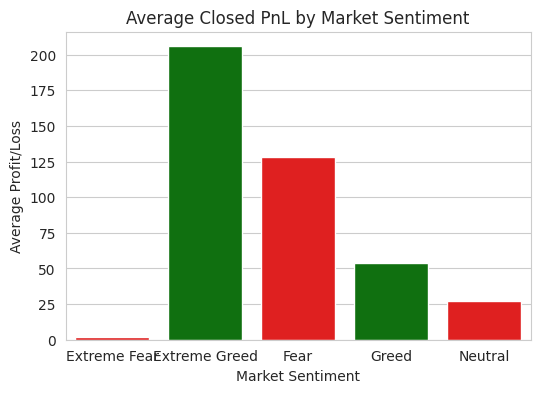

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

avg_pnl = valid_rows.groupby('Classification')['closed_pnl'].mean()
print("Average Closed PnL by Market Sentiment:")
print(avg_pnl)

plt.figure(figsize=(6,4))
sns.barplot(x=avg_pnl.index, y=avg_pnl.values, palette=["red", "green"])
plt.title("Average Closed PnL by Market Sentiment")
plt.ylabel("Average Profit/Loss")
plt.xlabel("Market Sentiment")
plt.savefig(f"ds_{your_name}/outputs/avg_pnl_by_sentiment.png")
plt.show()


Total Trading Volume (USD) by Market Sentiment:
Classification
Extreme Fear      9580240.04
Extreme Greed    18223760.27
Fear             79674391.06
Greed            57045815.74
Neutral          11939551.21
Name: size_usd, dtype: float64


/tmp/ipython-input-3356100441.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=volume_by_sentiment.index, y=volume_by_sentiment.values, palette=["orange", "blue"])
/tmp/ipython-input-3356100441.py:6: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=volume_by_sentiment.index, y=volume_by_sentiment.values, palette=["orange", "blue"])


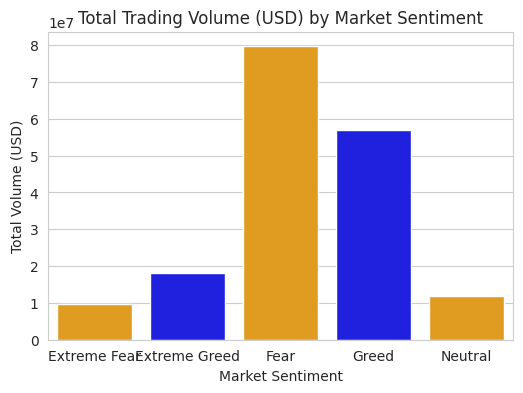

In [45]:
volume_by_sentiment = valid_rows.groupby('Classification')['size_usd'].sum()
print("Total Trading Volume (USD) by Market Sentiment:")
print(volume_by_sentiment)

plt.figure(figsize=(6,4))
sns.barplot(x=volume_by_sentiment.index, y=volume_by_sentiment.values, palette=["orange", "blue"])
plt.title("Total Trading Volume (USD) by Market Sentiment")
plt.ylabel("Total Volume (USD)")
plt.xlabel("Market Sentiment")
plt.savefig(f"ds_{your_name}/outputs/volume_usd_by_sentiment.png")
plt.show()


Buy/Sell Trade Counts by Market Sentiment:
side             BUY  SELL
Classification            
Extreme Fear    1168  1158
Extreme Greed   1661  3960
Fear            7307  6562
Greed           5407  5885
Neutral         1020  1736


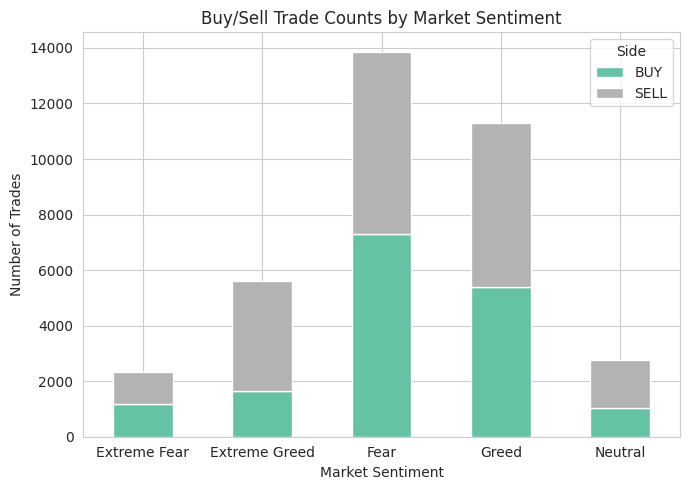

In [46]:
buy_sell_count = valid_rows.groupby(['Classification', 'side']).size().unstack(fill_value=0)

print("Buy/Sell Trade Counts by Market Sentiment:")
print(buy_sell_count)

buy_sell_count.plot(kind='bar', stacked=True, figsize=(7,5), colormap='Set2')
plt.title("Buy/Sell Trade Counts by Market Sentiment")
plt.ylabel("Number of Trades")
plt.xlabel("Market Sentiment")
plt.xticks(rotation=0)
plt.legend(title='Side')
plt.tight_layout()
plt.savefig(f"ds_{your_name}/outputs/buy_sell_by_sentiment.png")
plt.show()


In [47]:
summary = valid_rows.groupby('Classification').agg({
    'closed_pnl': ['mean', 'sum'],
    'size_usd': ['sum', 'mean'],
    'account': 'nunique'
}).reset_index()

summary.columns = ['Classification', 'Avg_Closed_PnL', 'Sum_Closed_PnL', 'Sum_Volume_USD', 'Avg_Volume_USD', 'Unique_Accounts']

summary.to_csv(f"ds_{your_name}/csv_files/summary_by_sentiment.csv", index=False)
print("Summary saved to csv_files/summary_by_sentiment.csv")


Summary saved to csv_files/summary_by_sentiment.csv


In [48]:
!pip install fpdf --quiet
from fpdf import FPDF

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", 'B', 16)
pdf.cell(0, 10, "Trading Behavior & Market Sentiment Report", ln=True, align="C")

pdf.set_font("Arial", size=12)
pdf.ln(10)
pdf.multi_cell(0, 8,
    f"This report analyzes trading behavior aligned with Bitcoin market sentiment.\n\n"
    f"Average Profit/Loss during Greed: {avg_pnl.get('Greed', 0):.2f}\n"
    f"Average Profit/Loss during Fear: {avg_pnl.get('Fear', 0):.2f}\n"
    f"Total Trading Volume during Greed: {volume_by_sentiment.get('Greed', 0):,.2f} USD\n"
    f"Total Trading Volume during Fear: {volume_by_sentiment.get('Fear', 0):,.2f} USD\n"
    f"Unique trader accounts analyzed: {summary['Unique_Accounts'].sum()}\n\n"
    f"Visual outputs are saved in the outputs/ folder."
)

pdf.output(f"ds_{your_name}/ds_report.pdf")
print("PDF report saved as ds_report.pdf")


  Preparing metadata (setup.py) ... done
PDF report saved as ds_report.pdf


In [49]:
!zip -r ds_{your_name}.zip ds_{your_name}
print(f"Folder zipped as ds_{your_name}.zip")


  adding: ds_AsfiyaSuzain/ (stored 0%)
  adding: ds_AsfiyaSuzain/outputs/ (stored 0%)
  adding: ds_AsfiyaSuzain/outputs/avg_pnl_by_sentiment.png (deflated 15%)
  adding: ds_AsfiyaSuzain/outputs/volume_usd_by_sentiment.png (deflated 14%)
  adding: ds_AsfiyaSuzain/outputs/buy_sell_by_sentiment.png (deflated 18%)
  adding: ds_AsfiyaSuzain/ds_report.pdf (deflated 31%)
  adding: ds_AsfiyaSuzain/csv_files/ (stored 0%)
  adding: ds_AsfiyaSuzain/csv_files/fear_greed_index.csv (deflated 77%)
  adding: ds_AsfiyaSuzain/csv_files/summary_by_sentiment.csv (deflated 35%)
  adding: ds_AsfiyaSuzain/csv_files/historical_trader_data.csv (deflated 80%)
  adding: ds_AsfiyaSuzain/README.md (stored 0%)
Folder zipped as ds_AsfiyaSuzain.zip
